## 1.Importing Libraries

In [10]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import gc
import os
import sys
module_path = "../../src"
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.encoding import ClassicEncoding,TargetEncoding
from modeling.regression import Trainer_Boosting
from lofo import LOFOImportance, Dataset, plot_importance
from utils.utils import *   
pd.options.display.max_rows = 9999
DATA_PATH    = '../../Data'
PATH_MODEL = '../../SavedModels/model_past' 
PROJECT_NAME = 'MODEL_PAST'
FILL_NA  = 0
SEED = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def merge_with_features_not_target(train,test,path = '../../Data/DatasetsGenerated/features_v2'):
    train.set_index(['id','mes'],inplace = True)
    test.set_index(['id','mes'],inplace = True)
    print(f'Original Train Shape: {train.shape} - Test shape: {test.shape}')
    for file in os.listdir(path):
        if '.parquet' in file:
            if 'target' in file:
                pass
            else:
                print(f'*********** Merging with {file} ********** ')
                with open(os.path.join(path,'features_list',file.replace('parquet','txt')), "rb") as fp:   # Unpickling
                    features = pickle.load(fp)
                tmp = pd.read_parquet(os.path.join(path,file),columns = features + ['id'])
                tmp.set_index(['id','mes'],inplace = True)
                train  = train.join(tmp, how='left')
                test  = test.join(tmp, how='left')
                print(f' {file} : Train After merge Shape: {train.shape} - Test After Merge: {test.shape}')
                del tmp
    return train,test

def save_model(trainer,train_df,test_df,model_path,group_name):
    output_folder = os.path.join(model_path,group_name)
    print('output_folder: ',output_folder)
    for fold,model in enumerate(trainer.models):
        os.makedirs(os.path.join(output_folder,f'fold_{fold}'), exist_ok=True)
        pickle.dump(model, open(os.path.join(output_folder,f'fold_{fold}','model.pkl'), 'wb'))
    train_df[['id','mes','oof']].to_csv(os.path.join(output_folder,'oof.csv'),index = False)
    test_df[['id','mes','preds']].to_csv(os.path.join(output_folder,'part1_test.csv'),index = False)
    print('Models Saved')

## 2. Load Datasets

In [12]:
%%time
# Reading parent datasets
train_all,test_all = get_reference_datasets(DATA_PATH = DATA_PATH)
# Reading Dataframes
train = get_train_data('folds_new_clients_model.parquet.gzip',DATA_PATH)[['id','mes','target_mes','fold']]
test  = get_test_data(segment = 'groupkfold_client',DATA_PATH = DATA_PATH)[['id','mes']]
print('Train & Test shape:',train.shape,test.shape)
# Merge with features dataset:
train,test = merge_with_features_not_target(train,test,path = '../../Data/DatasetsGenerated/features_v2')
print('Train & Test shape:',train.shape,test.shape)
train.reset_index(inplace = True)
test.reset_index(inplace = True)

Train & Test shape: (657815, 4) (176201, 2)
Original Train Shape: (657815, 2) - Test shape: (176201, 0)
*********** Merging with features_v2_level0.parquet ********** 
 features_v2_level0.parquet : Train After merge Shape: (657815, 543) - Test After Merge: (176201, 541)
*********** Merging with features_v2_level1_num_by_cat_mes.parquet ********** 
 features_v2_level1_num_by_cat_mes.parquet : Train After merge Shape: (657815, 822) - Test After Merge: (176201, 820)
*********** Merging with features_v2_level1_num_by_cat.parquet ********** 
 features_v2_level1_num_by_cat.parquet : Train After merge Shape: (657815, 1177) - Test After Merge: (176201, 1175)
*********** Merging with features_v2_level1_var_aggs.parquet ********** 
 features_v2_level1_var_aggs.parquet : Train After merge Shape: (657815, 1222) - Test After Merge: (176201, 1220)
*********** Merging with features_v2_level0_client_and_category_vars.parquet ********** 
 features_v2_level0_client_and_category_vars.parquet : Train Afte

## 3.Modeling

### 3.1 Lightgbm

In [4]:
def exp_mae_lgbm(preds,data):
    from sklearn.metrics import mean_absolute_error
    """Calculate exp_mae_metric"""
    labels = data.get_label()
    metric = mean_absolute_error(np.exp(labels)-1,np.exp(preds)-1)
    return 'exp_mae', metric, False

### 3.1.1 Encoding

In [5]:
%%time
cat_features = train.select_dtypes('object').drop(columns = ['id']).columns.to_list() + ['mes']
enc = ClassicEncoding(cat_features,name_encoding = 'LE')
train_df,test_df = train.copy(),test.copy()
train_df = enc.fit_transform(train_df)
test_df  = enc.transform(test_df)

Mode: Missing as new category
Label Encoding:  label_categoria_tipo_cat
Label Encoding:  label_tipo_ban_categoria_tipo_cli
Label Encoding:  label_tipo_cat_tipo_cli
Label Encoding:  label_tipo_ban_tipo_seg_tipo_com
Label Encoding:  label_tipo_ban_tipo_seg_tipo_cli
Label Encoding:  label_tipo_seg_categoria
Label Encoding:  label_tipo_ban_tipo_cat
Label Encoding:  label_tipo_seg_categoria_tipo_com
Label Encoding:  label_tipo_com_tipo_cat_tipo_cli
Label Encoding:  label_tipo_ban_tipo_com
Label Encoding:  label_tipo_cat
Label Encoding:  label_tipo_ban_tipo_seg_tipo_com_tipo_cli
Label Encoding:  label_tipo_ban_categoria
Label Encoding:  label_tipo_seg_tipo_cli
Label Encoding:  label_categoria_tipo_com
Label Encoding:  label_tipo_ban_tipo_com_tipo_cli
Label Encoding:  label_tipo_ban_tipo_cat_tipo_cli
Label Encoding:  label_categoria_tipo_com_tipo_cli
Label Encoding:  label_tipo_com_tipo_cat
Label Encoding:  label_categoria_tipo_cat_tipo_cli
Label Encoding:  label_tipo_ban_categoria_tipo_com
L

### 3.1.2 Target Transform

<AxesSubplot:xlabel='target_mes', ylabel='Density'>

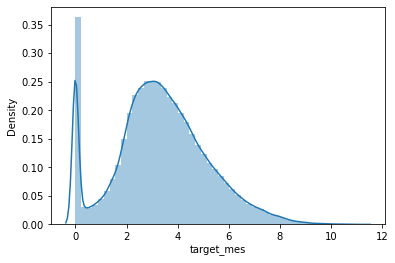

In [6]:
train_df['target_mes'] = np.log(train_df['target_mes']+1)
sns.distplot(train_df['target_mes'])

### 3.1.3 Training

In [7]:
%%time
model_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'learning_rate': 0.01,
        'num_leaves':24,
        'metric': 'None',
        "min_child_samples": 20,
        "max_depth" : 7,
        'feature_fraction':  0.7,
        "bagging_freq": 1, # at K iterations perform bagging
        'bagging_fraction': 0.75, # percentage of bagging
        'force_col_wise':True,
        'cat_smooth': 100, 
        'bagging_seed':42,
        'lambda_l1':2.5,
        'lambda_l2':2.0,
        'verbose': -1,
        'n_jobs':48

}
cat_columns = [i for i in train_df.columns.to_list() if i.startswith('label_')]
trainer_lgbm = Trainer_Boosting(train_df.drop(columns = ['id']),
                           model_params,
                           train_params = {'model_name'      : 'lightgbm',
                                           'fold_column'     : 'fold',
                                           'target_column'   : 'target_mes',
                                           'cat_vars'        : cat_columns,
                                           'metric'          : 'log_mae',
                                           'feval'           : exp_mae_lgbm,
                                           'early_stopping'  : 200,
                                           'max_boost_round' : 16000,
                                           'run_wandb'       : True,
                                           'project_name'    : PROJECT_NAME,
                                           'group_name'      : 'ligthgbm_featureset2_model_past_target_log'}
                          )
trainer_lgbm.train()

Features for training: ['std_VAR30_sum_34M', 'max_VAR12_sum_12M', 'max_VAR23_trx_34M', 'mean_VAR23_prom_9M', 'mean_VAR16_sum_34M', 'ratio_VAR1_sum_VAR22_sum', 'ratio_VAR24_trx_VAR25_trx', 'max_VAR23_prom_12M', 'std_VAR5_prom_18M', 'max_VAR3_trx_18M', 'max_VAR3_trx_34M', 'ratio_VAR24_sum_VAR9_sum', 'std_VAR23_sum_34M', 'ratio_VAR4_sum_VAR22_sum', 'ratio_VAR23_sum_VAR27_sum', 'max_VAR11_sum_34M', 'ratio_VAR1_trx_VAR3_trx', 'mean_VAR3_sum_12M', 'min_VAR25_sum_34M', 'ratio_VAR5_trx_VAR28_trx', 'mean_VAR25_prom_9M', 'mean_VAR11_sum_34M', 'ratio_VAR5_sum_VAR26_trx', 'mean_VAR23_trx_18M', 'min_VAR4_trx_34M', 'max_VAR30_sum_18M', 'FLG_COVID', 'min_VAR25_trx_34M', 'ratio_VAR1_sum_VAR19_sum', 'count_nan', 'mean_VAR16_sum_18M', 'mean_VAR6_trx_34M', 'min_VAR25_prom_9M', 'mean_VAR30_sum_34M', 'std_VAR4_trx_12M', 'min_VAR4_sum_2M', 'ratio_VAR1_trx_VAR25_trx', 'max_VAR23_sum_12M', 'ratio_VAR23_sum_VAR8_trx', 'VAR5_sum', 'ratio_VAR1_sum_VAR24_sum', 'max_VAR5_prom_12M', 'min_VAR23_prom_12M', 'std_VAR11

Training until validation scores don't improve for 200 rounds
[50]	training's exp_mae: 165.639	valid_1's exp_mae: 164.376
[100]	training's exp_mae: 156.286	valid_1's exp_mae: 154.754
[150]	training's exp_mae: 146.913	valid_1's exp_mae: 145.412
[200]	training's exp_mae: 138.566	valid_1's exp_mae: 137.473
[250]	training's exp_mae: 131.524	valid_1's exp_mae: 130.963
[300]	training's exp_mae: 125.609	valid_1's exp_mae: 125.678
[350]	training's exp_mae: 120.935	valid_1's exp_mae: 121.838
[400]	training's exp_mae: 117.062	valid_1's exp_mae: 118.89
[450]	training's exp_mae: 114.103	valid_1's exp_mae: 116.689
[500]	training's exp_mae: 111.77	valid_1's exp_mae: 114.951
[550]	training's exp_mae: 109.54	valid_1's exp_mae: 113.304
[600]	training's exp_mae: 107.423	valid_1's exp_mae: 111.652
[650]	training's exp_mae: 105.566	valid_1's exp_mae: 110.308
[700]	training's exp_mae: 103.883	valid_1's exp_mae: 109.062
[750]	training's exp_mae: 102.441	valid_1's exp_mae: 107.95
[800]	training's exp_mae: 10

Training until validation scores don't improve for 200 rounds
[50]	training's exp_mae: 162.682	valid_1's exp_mae: 176.269
[100]	training's exp_mae: 153.274	valid_1's exp_mae: 167.013
[150]	training's exp_mae: 144.155	valid_1's exp_mae: 158.156
[200]	training's exp_mae: 136.064	valid_1's exp_mae: 150.22
[250]	training's exp_mae: 128.954	valid_1's exp_mae: 143.327
[300]	training's exp_mae: 123.072	valid_1's exp_mae: 137.674
[350]	training's exp_mae: 118.683	valid_1's exp_mae: 133.433
[400]	training's exp_mae: 115.185	valid_1's exp_mae: 129.999
[450]	training's exp_mae: 112.175	valid_1's exp_mae: 127.108
[500]	training's exp_mae: 109.692	valid_1's exp_mae: 124.835
[550]	training's exp_mae: 107.447	valid_1's exp_mae: 122.921
[600]	training's exp_mae: 105.319	valid_1's exp_mae: 121.295
[650]	training's exp_mae: 103.386	valid_1's exp_mae: 119.799
[700]	training's exp_mae: 101.782	valid_1's exp_mae: 118.823
[750]	training's exp_mae: 100.152	valid_1's exp_mae: 117.85
[800]	training's exp_mae: 

Training until validation scores don't improve for 200 rounds
[50]	training's exp_mae: 165.299	valid_1's exp_mae: 166.197
[100]	training's exp_mae: 156.078	valid_1's exp_mae: 157.014
[150]	training's exp_mae: 147.059	valid_1's exp_mae: 147.947
[200]	training's exp_mae: 139.183	valid_1's exp_mae: 139.598
[250]	training's exp_mae: 132.393	valid_1's exp_mae: 132.077
[300]	training's exp_mae: 126.619	valid_1's exp_mae: 125.542
[350]	training's exp_mae: 122.065	valid_1's exp_mae: 120.63
[400]	training's exp_mae: 118.299	valid_1's exp_mae: 116.873
[450]	training's exp_mae: 115.202	valid_1's exp_mae: 114.027
[500]	training's exp_mae: 112.56	valid_1's exp_mae: 111.888
[550]	training's exp_mae: 110.163	valid_1's exp_mae: 110.177
[600]	training's exp_mae: 107.976	valid_1's exp_mae: 108.798
[650]	training's exp_mae: 105.872	valid_1's exp_mae: 107.656
[700]	training's exp_mae: 103.859	valid_1's exp_mae: 106.759
[750]	training's exp_mae: 102.245	valid_1's exp_mae: 106.081
[800]	training's exp_mae: 

Training until validation scores don't improve for 200 rounds
[50]	training's exp_mae: 166.401	valid_1's exp_mae: 161.647
[100]	training's exp_mae: 157.078	valid_1's exp_mae: 152.566
[150]	training's exp_mae: 147.767	valid_1's exp_mae: 143.518
[200]	training's exp_mae: 139.416	valid_1's exp_mae: 135.696
[250]	training's exp_mae: 132.125	valid_1's exp_mae: 129.276
[300]	training's exp_mae: 126.165	valid_1's exp_mae: 124.06
[350]	training's exp_mae: 121.527	valid_1's exp_mae: 120.135
[400]	training's exp_mae: 118.004	valid_1's exp_mae: 117.226
[450]	training's exp_mae: 115.006	valid_1's exp_mae: 114.783
[500]	training's exp_mae: 112.494	valid_1's exp_mae: 112.865
[550]	training's exp_mae: 110.304	valid_1's exp_mae: 111.17
[600]	training's exp_mae: 108.301	valid_1's exp_mae: 109.706
[650]	training's exp_mae: 106.445	valid_1's exp_mae: 108.46
[700]	training's exp_mae: 104.597	valid_1's exp_mae: 107.301
[750]	training's exp_mae: 102.991	valid_1's exp_mae: 106.388
[800]	training's exp_mae: 1

Training until validation scores don't improve for 200 rounds
[50]	training's exp_mae: 167.054	valid_1's exp_mae: 159.093
[100]	training's exp_mae: 157.596	valid_1's exp_mae: 150.026
[150]	training's exp_mae: 148.231	valid_1's exp_mae: 141.277
[200]	training's exp_mae: 139.724	valid_1's exp_mae: 133.682
[250]	training's exp_mae: 132.269	valid_1's exp_mae: 127.485
[300]	training's exp_mae: 126.136	valid_1's exp_mae: 122.861
[350]	training's exp_mae: 121.593	valid_1's exp_mae: 119.504
[400]	training's exp_mae: 117.976	valid_1's exp_mae: 116.747
[450]	training's exp_mae: 115.107	valid_1's exp_mae: 114.527
[500]	training's exp_mae: 112.669	valid_1's exp_mae: 112.893
[550]	training's exp_mae: 110.282	valid_1's exp_mae: 111.468
[600]	training's exp_mae: 108.102	valid_1's exp_mae: 110.236
[650]	training's exp_mae: 106.189	valid_1's exp_mae: 109.29
[700]	training's exp_mae: 104.341	valid_1's exp_mae: 108.438
[750]	training's exp_mae: 102.635	valid_1's exp_mae: 107.641
[800]	training's exp_mae:

In [8]:
trainer_lgbm.results

,Model_Name,Mean Valid log_mae,Std Valid log_mae,Mean Train log_mae,Std Train log_mae,OOF log_mae,Diff log_mae,Time
0,lightgbm,100.309343,2.600412,74.419087,1.55152,100.301717,-25.890256,2621862 s


In [10]:
train_df['oof'] = np.exp(trainer_lgbm.oof)-1
train_df['mes'] = enc.dict_le['label_mes'].inverse_transform(train_df['label_mes']).astype(int)

In [11]:
################################
########## Preds ###############
################################
test_df['preds'] =  (np.exp(trainer_lgbm.predict(test_df,preds_returns = 'median'))-1).clip(0)
test_df['mes'] = enc.dict_le['label_mes'].inverse_transform(test_df['label_mes']).astype(int)
test_df_part1  = test_all.merge(test_df[['id','mes','preds']],on = ['id','mes'],how = 'inner')

100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


Train: oof_median: 23.34828409905633, preds_median: 22.611805348915414


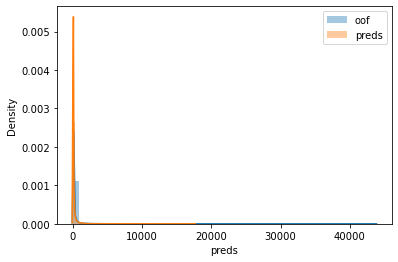

In [12]:
print(f"Train: oof_median: {train_df['oof'].median()}, preds_median: {test_df['preds'].median()}")
sns.distplot(train_df['oof'],label = 'oof')
sns.distplot(test_df_part1['preds'],label = 'preds')
plt.legend()

In [13]:
save_model(trainer_lgbm,train_df,test_df,PATH_MODEL,'ligthgbm_featureset2_model_past_target_log')

output_folder:  ../../SavedModels/model_past/ligthgbm_featureset2_model_past_target_log
Models Saved


In [14]:
del train_df,test_df